<img src="./img/hpe_logo.png" alt="HPE Logo" width="300">

<h1>Demo of the Enterprise Machine Learning/Data Science Platform</h1>

<h5>Date: 09/21/23</h5>
<h5>Version: 1.0</h5>
<h5>Author(s): andrew.mendez

# Overview
## We will build an End to End ML Pipeline to train and deploy AI to detect Aircraft in Satellite Imagery
<img src="./img/model-pred.png" alt="Enterprise Machine Learning platform architecture" width="850">


# How will we build this?
<img src="./img/PDK_Demo_Overview.png" alt="Enterprise Machine Learning platform architecture" width="850">

# What are they Key Challenges with delivering world class AI at the speed of the mission?

## Going from a research project to production
### How can you equip teams of researchers

* Good Data, Good Models, and Good Infrastructure
* **Good Infrastructure is the hardest, and the biggest issue that cause 80-90% of ML projects to fail**


What does Good AI Infrastructure Look Like:
* Data Infrastructure:
    * Data Management
    * Data Versioning
    * Pipeline Orchestration
* Training Infrastructure
    * Resource Management
    * Distributed Training
    * Fault Tolerance and Resumption
    * Experiment Tracking
    * IDE for developers to develop models
    * Logging and Visualizing Metrics
    * Hyper-parameter search
* Serving Infrastructure
    * Automatic Deployments
    * Versioning Models
    * Automatic Resource Allocation



# How the HPE Machine Learning/Data Science Platform Helps:

Built off two leading AI software platforms: Pachyderm and Determined.AI (via acquisition.)

## What does the HPE ML/DS Plaform provide:
* Out-of-the-box Data Infrastructure (Pachyderm):
    * Data Management
    * Data Versioning
    * Pipeline Orchestration
* Out-of-the-box Training Infrastructure (Determined.AI)
    * Resource Management
    * Distributed Training
    * Multi-node training (LLMs)
    * Fault Tolerance and Resumption at scale
    * Experiment Tracking
    * IDE for developers to develop models
    * Logging and Visualizing Metrics
    * Hyper-parameter search at scale
* Out-of-the-box Serving Infrastructure (KServe)
    * Automatic Deployments
    * Versioning Models
    * Automatic Resource Allocation
    
## Impact of HPE ML Platform:
* Less Lines of code to manage data, train, and deploy at scale
* Out-of-the-box support for distributed training, hyperparameter search, and experiment tracking
* Ensure the productivity and success of your team delivering great models at the speed of the mission

<img src="./img/platform_step3.png" alt="Enterprise Machine Learning platform architecture" width="850">

# Outline of Demo:
* Create Data Repo and Upload data
* Data Exploration
* Create Simple Baseline
* Migrate Training and Inference into Scalable, Automated E2E Ops:
    * Create Training Pipeline
    * Create Deployment Pipeline
* Trigger End-to-End Pipeline Execution with new class label
* Explore deployed endpoint on unseen images

<h3>Import modules and define functions</h3>
The cell below imports all modules and libraries required to run the demo.

In [1]:
# General modules
import os
import random
import numpy as np
import time
# Torch modules
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import json
# Image modules
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import functions for downloading data
from load_data import download_pach_repo, download_data, get_train_transforms

# Import Determined Client
from determined.experimental import client as det
from determined import pytorch
from utils import calculate_coco_stats, visualize_coco_annotations, load_model
# Remove warnings
import warnings

import python_pachyderm
from python_pachyderm.service import pps_proto

warnings.filterwarnings('ignore')

<h1>Interactive Experimentation </h1>

<img src="./img/platform_step1.png" alt="Enterprise Machine Learning platform architecture" width="850">

In [2]:
# Define variables for Pachyderm connection
pachyderm_host = "10.239.255.3"
pachyderm_port = 9090
repo = "data"
data_dir = './data/xview_2class_full/'
branch = "master"
project = "object-detection-demo"
download_dir = "./data_downloaded"
token = " "

In [3]:
# instantiate pachyderm client
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)


# Create Data Repo and Upload data to Pachyderm

In [ ]:
try:
    # try to create project (if its not created)
    client.create_project(project)
    print("Created Project {}".format(project))
except Exception as e:
    # errors because project is already created
    print("Failed to create project: {}...will try to upload to existing repo".format(project))
    pass

try:
    client.create_repo(repo,project_name=project)# This line creates a Pachyderm Repo
except Exception as e:
    print("Failed to create data repo: {}...will try to upload to existing repo".format(repo))
    pass

source_dir  = data_dir
# Populate the input repos
def insert_data(client,name,source_data_dir,project):
    print("Inserting {} data...".format(name))
    with client.commit(name, "master",project_name=project) as c:
        python_pachyderm.put_files(client, source_data_dir, c, "/")
                
        return c

d_commit = insert_data(client,repo,source_data_dir=source_dir,project=project)

# Wait for the commits to finish
print("Waiting for commits to finish...")
for commit in [client.wait_commit(c.id)[0] for c in [d_commit]]:
    print(commit)

Failed to create project: object-detection-demo...will try to upload to existing repo
Failed to create data repo: data...will try to upload to existing repo
Inserting data data...
Waiting for commits to finish...
commit {
  branch {
    repo {
      name: "data"
      type: "user"
      project {
        name: "object-detection-demo"
      }
    }
    name: "master"
  }
  id: "929aee8793104f35960df3ed7c5e4813"
}
origin {
  kind: USER
}
parent_commit {
  branch {
    repo {
      name: "data"
      type: "user"
      project {
        name: "object-detection-demo"
      }
    }
    name: "master"
  }
  id: "6dab66db1b914a1a9f21f686871d0117"
}
started {
  seconds: 1698181318
  nanos: 775022000
}
finishing {
  seconds: 1698181319
  nanos: 798265000
}
finished {
  seconds: 1698181320
  nanos: 199019000
}
size_bytes_upper_bound: 3265898
details {
  size_bytes: 3265898
  compacting_time {
    nanos: 313473050
  }
  validating_time {
    nanos: 82243422
  }
}



<h3>Inspect first version of data</h3>

In [ ]:
# Call download, store paths in files
files = download_data(pachyderm_host, pachyderm_port, repo, branch, project, download_dir, token)

Starting to download dataset: data@master --> ./data_downloaded
Download operation successful!


<h3> Some light data exploration</h3>
We see how many examples and how many labels we have to each class in our 2 class dataset

In [ ]:
FILE_PATH='./data_downloaded/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
(num_annotations, 
 cat_ids, 
 cat_names, 
 annotations_per_category, 
 min_annotations, 
 max_annotations, 
 average_annotations, 
 min_annotation_area,
 max_annotation_area,
 avg_annotation_area,
 min_annotation_area_per_category, 
 max_annotation_area_per_category) = calculate_coco_stats(FILE_PATH)
print("Number of images:", num_annotations)
print(f"Number of Unique Categories: {len(cat_ids)}")
print(cat_ids)  # The IDs are not necessarily consecutive.

print("Category IDs:")
print("Categories Names: ", cat_names)
# Print or use annotations_per_category as needed
print("Number of annotations per category:")
print(annotations_per_category)
# Print or use the calculated metrics as needed
print("Minimum number of annotations for an image:", min_annotations)
print("Maximum number of annotations in an image:", max_annotations)
print("Average number of annotations per image:", average_annotations)

print("Minimum annotation area:", min_annotation_area)
print("Maximum annotation area:", max_annotation_area)
print("Average annotation area:", avg_annotation_area)

print("\nMinimum annotation area per category:")
print(min_annotation_area_per_category)

print("\nMaximum annotation area per category:")
print(max_annotation_area_per_category)

COCO annotation file:  ./data_downloaded/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 73
Number of Unique Categories: 2
[1, 2]
Category IDs:
Categories Names:  ['Fixed-wing Aircraft', 'Cargo Plane']
Number of annotations per category:
{'Fixed-wing Aircraft': 5, 'Cargo Plane': 68}
Minimum number of annotations for an image: 0
Maximum number of annotations in an image: 10
Average number of annotations per image: 2.28125
Minimum annotation area: 1314
Maximum annotation area: 22650
Average annotation area: 6178.082191780822

Minimum annotation area per category:
{'Cargo Plane': 1314, 'Fixed-wing Aircraft': 1357}

Maximum annotation area per category:
{'Cargo Plane': 22650, 'Fixed-wing Aircraft': 14820}


### Here we visualize our images and labels

In [ ]:
# !ls /run/determined/workdir/shared_fs/01\ -\ Users/andrew.mendez/e2e_blogposts/ngc_blog/xview_2class_full/train_images_rgb_no_neg_filt_32/train_images_640_02_filt_32

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


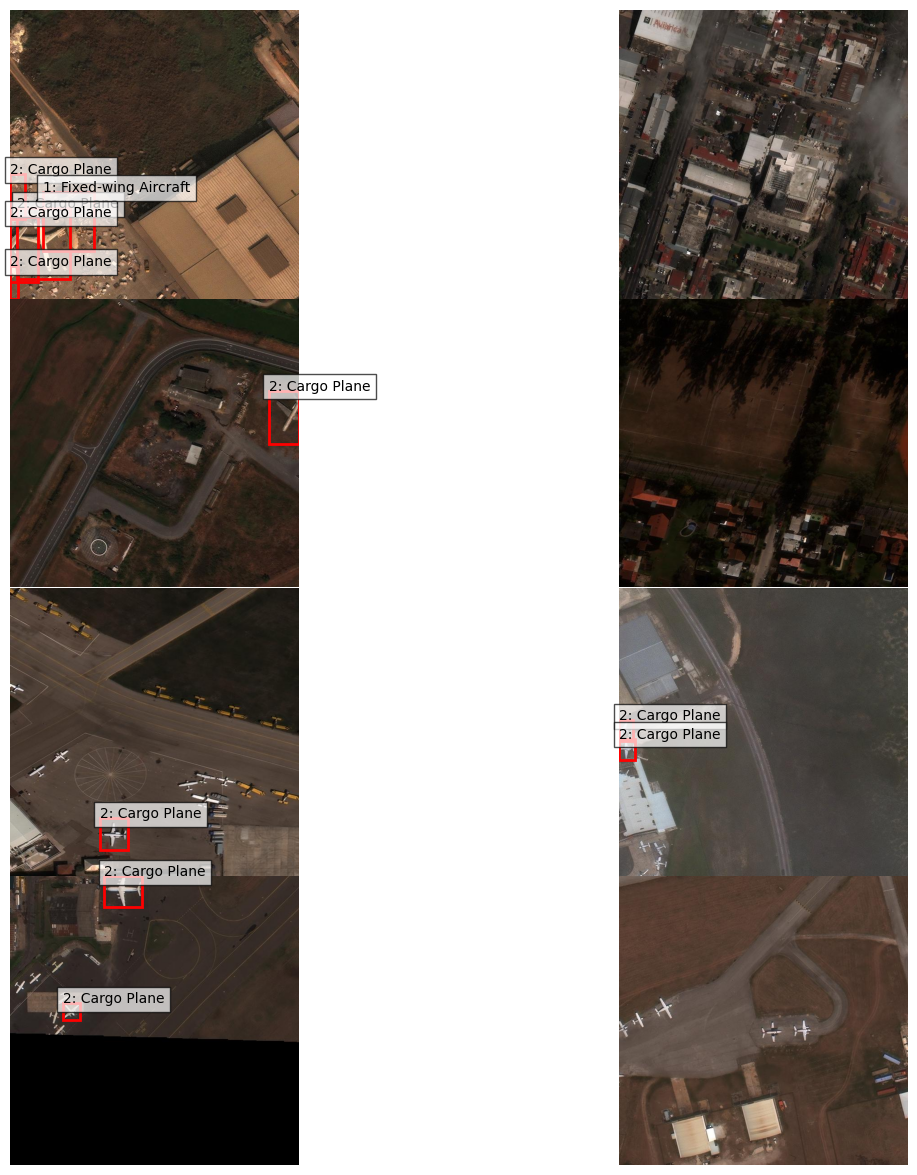

In [ ]:
coco_ann_file_path = './data_downloaded/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
coco_img_dir = './data_downloaded/train_images_rgb_no_neg_filt_32/train_images_640_02_filt_32'
visualize_coco_annotations(coco_ann_file_path, coco_img_dir)

In [ ]:
# Lets import libraries needed to train a model without MLDE/Determined.AI
import datetime
import os
import time

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn

# from detection_utils.coco import get_coco, get_coco_kp
from detection_utils.data import build_xview_dataset_filtered
from detection_utils.group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from detection_utils.engine import train_and_eval, eval_model

# from detection_utils.train import get_dataset, get_transform
from detection_utils.models import build_frcnn_model, build_frcnn_model_finetune, load_model_ddp
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from attrdict import AttrDict
import matplotlib.pyplot as plt

TORCHVISION_VERSION:  0.13.0+cu113 /opt/conda/lib/python3.8/site-packages/torchvision/__init__.py
TORCH_VERSION:  1.12.0+cu113 /opt/conda/lib/python3.8/site-packages/torch/__init__.py


<h2> Create Simple Baseline (without MLDE/Determined.AI)</h2>

### Create data set class (inherit from Pytorch dataset)
```python
class LocalBackend:
    """
    This class will load data from harddrive.
    COCO dataset will be downloaded from source in model_def.py if
    local backend is specified.
    """

    def __init__(self, outdir):
        assert os.path.isdir(outdir)
        self.outdir = outdir

    def get(self, filepath):
        with open(os.path.join(self.outdir, filepath), "rb") as f:
            img_str = f.read()
        return img_str


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        backend,
        root_dir,
        img_folder,
        ann_file,
        transforms,
        return_masks,
        catIds=[],
    ):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.img_folder = img_folder
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)
        elif backend == "local":
            self.backend = LocalBackend(root_dir)
        else:
            raise NotImplementedError

        self.catIds = catIds
        self.catIds = self.coco.getCatIds()
        '''
        Remapping to set background class to zero, so can support FasterRCNN models
        '''
        self.catIdtoCls = {
            catId: i+1 for i, catId in zip(range(len(self.catIds)), self.catIds)
        }
        self.clstoCatId = {
            v:k for k,v in self.catIdtoCls.items()
        }
        self.num_classes = len(list(self.catIdtoCls.values()))+1

    def __getitem__(self, idx):
        coco = self.coco
        img_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.catIds)
        target = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]["file_name"]
        img_bytes = BytesIO(self.backend.get(os.path.join(self.img_folder, path)))

        img = Image.open(img_bytes).convert("RGB")
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        target["labels"] = torch.tensor(
                [self.catIdtoCls[l.item()] for l in target["labels"]], dtype=torch.int64
            )

        return img, target

    def __len__(self):
        return len(self.ids)
```

In [ ]:
def unwrap_collate_fn(batch):
    batch = list(zip(*batch))
    return tuple(batch)

data_dir = os.path.join('.', "data_downloaded")
print(data_dir)
dataset, num_classes = build_xview_dataset_filtered(image_set='train',args=AttrDict({
                                                'data_dir':data_dir,
                                                'backend':'local',
                                                'masks': None,
                                                }))
print("--num_classes: ",num_classes)
batch_size = 4
data_loader = torch.utils.data.DataLoader(
                                 dataset, 
                                 batch_size=batch_size,
                                 batch_sampler=None,
                                 shuffle=True,
                                 num_workers=1, 
                                 collate_fn=unwrap_collate_fn)
print(data_dir)
dataset_test, _ = build_xview_dataset_filtered(image_set='val',args=AttrDict({
                                                'data_dir':data_dir,
                                                'backend':'local',
                                                'masks': None,
                                                }))

./data_downloaded
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
--num_classes:  3
./data_downloaded
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


det_labels:  ['Fixed-wing Aircraft', 'Cargo Plane']


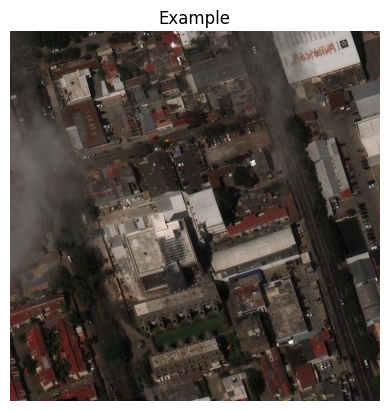

In [ ]:
# Labels used to translate category_id
det_labels = cat_names
print("det_labels: ",det_labels)
# Get one sample from the data set and show the image for validation
for sample in data_loader:
    img, targets = sample
    img = img[0].cpu()
    boxes = targets[0]['boxes'].cpu().numpy()
    labels = targets[0]['labels'].cpu().numpy()
    fig, ax = plt.subplots(1)
    ax.set_title("Example")
    ax.imshow(np.clip(img.permute(1, 2, 0), 0, 1))
    # Plot bounding boxes as rectangles on the image
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)

    plt.axis('off')
    plt.show()
    break

<h3>Step 4: Create DataLoader and model</h3>

In [12]:
# Create pytorch data loader
data_loader = torch.utils.data.DataLoader(
                                 dataset, 
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1, 
                                 collate_fn=unwrap_collate_fn)
print("NUMBER OF BATCHES IN COCO: ",len(data_loader))# 59143, 7392 for mini coco
data_loader_test = torch.utils.data.DataLoader(
                            dataset_test,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=1,
                            collate_fn=unwrap_collate_fn)
print("NUMBER OF BATCHES IN COCO Test: ",len(data_loader_test))# 59143, 7392 for mini coco

# Load FasterRCNN model (untrained) to GPU
model = build_frcnn_model_finetune(num_classes=num_classes,ckpt='/mnt/efs/shared_fs/determined/nb_fs/weights/frcnn_xview.pth')
model.cuda() if torch.cuda.is_available() else model.cpu()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup loss function and optimizer. Note: the loss function is built into the torchvision FasterRCNN model
optimizer = torch.optim.SGD(
            model.parameters(),
            lr=0.02,
            momentum=0.9,
            weight_decay=1e-4
        )

NUMBER OF BATCHES IN COCO:  8
NUMBER OF BATCHES IN COCO Test:  8
Loading pretrained model from /mnt/efs/shared_fs/determined/nb_fs/weights/frcnn_xview.pth...
Loading DDP checkpoint into a non-DDP model.


<h3>Run some training (overfitting on one batch)</h3>

In [13]:
# Create iterator for data loader
dataiter = iter(data_loader)

# Get a single batch to overfit on
inputs, targets = dataiter.next()

In [ ]:
# Fit model on dataset 2 times
import time
model.train()
loss_dict = {'loss_classifier':1, 'loss_box_reg': 1, 'loss_objectness': 1, 'loss_rpn_box_reg': 1, 'tr_time': 1}
# Initialize running sums and counts for each loss component
running_sums = {key: 0.0 for key in loss_dict.keys()}
running_counts = {key: 0 for key in loss_dict.keys()}
NUM_EPOCHS=1
for e in range(NUM_EPOCHS):
    for ind, batch in enumerate(data_loader):
        batch_time_start = time.time()
        images, targets = batch
        images = list(image.to(device, non_blocking=True) for image in images)
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses_reduced = sum(loss for loss in loss_dict.values())
        loss_value = losses_reduced.item()
        optimizer.zero_grad()
        losses_reduced.backward()
        optimizer.step()
        total_batch_time = time.time() - batch_time_start

        # Update running sums and counts for each loss component
        for key, value in loss_dict.items():
            running_sums[key] += value.item()
            running_counts[key] += 1

        # Calculate the running mean for each loss component
        running_means = {key: running_sums[key] / running_counts[key] for key in loss_dict.keys()}

        # Add the total batch time to the loss_dict
        running_means['tr_time'] = total_batch_time
        if ind%4 == 0:
            # Print the contents in a nice, formatted manner
            print(f"Epoch {e}/{NUM_EPOCHS}")
            print(f"{ind}/{len(data_loader)} ", end="")
            for key, value in running_means.items():
                if key not in ['accuracy', 'val_loss', 'val_accuracy']:
                    print(f"{key}: {value:.4f} - ", end="")
            print()

print('\nFinished Training')

<h3> Validate model trained in notebook</h3>

In [ ]:
import torch
import matplotlib.pyplot as plt

model.eval()
det_labels = cat_names
print("det_labels: ",det_labels)

with torch.no_grad():
    for sample in data_loader_test:
        images, targets = sample
        # print(len(images),targets)

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(len(images))
        fig, axs = plt.subplots(len(images), 2, figsize=(12, 6 * len(images)))

        for idx, (img, target) in enumerate(zip(images, targets)):
            img_np = img.clone().cpu().permute(1, 2, 0).numpy()

            # Ground truth
            axs[idx, 0].set_title("Ground Truth")
            axs[idx, 0].imshow(np.clip(img_np, 0, 1))
            boxes_gt = target['boxes'].cpu().numpy()
            labels_gt = target['labels'].cpu().numpy()
            for box, label in zip(boxes_gt, labels_gt):
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, edgecolor='red', linewidth=2, alpha=0.5)
                axs[idx, 0].add_patch(rect)
                # axs[idx, 0].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)
                axs[idx, 0].text(x_min, y_min - 5, f'Label: {label}', color='red', fontsize=10)

            # Model prediction
            axs[idx, 1].set_title("Model Prediction")
            axs[idx, 1].imshow(np.clip(img_np, 0, 1))
            outputs = model([img])
            if outputs[0]['boxes'].nelement() !=0:
                outputs = [{k: v.to('cpu') for k, v in output.items()} for output in outputs]
                merged_scores = torch.cat([d['scores'] for d in outputs])

                # Compute min, max, 50th percentile, and 95th percentile in merged_scores
                min_value = torch.min(merged_scores)
                max_value = torch.max(merged_scores)

                # Compute the 50th percentile using quantile
                percentile_50 = torch.quantile(merged_scores, 0.5)

                # Compute the 95th percentile using quantile
                percentile_95 = torch.quantile(merged_scores, 0.95)

                # Convert tensors to numpy arrays for easy printing
                min_value, max_value, percentile_50, percentile_95 = min_value.numpy(), max_value.numpy(), percentile_50.numpy(), percentile_95.numpy()

                print(f"Min Value: {min_value}")
                print(f"Max Value: {max_value}")
                print(f"50th Percentile: {percentile_50}")
                print(f"95th Percentile: {percentile_95}")
                boxes_pred = outputs[0]['boxes']
                labels_pred = outputs[0]['labels']
                scores_pred = outputs[0]['scores']
                idxs = scores_pred> 0.2
                boxes_pred = boxes_pred[idxs]
                labels_pred = labels_pred[idxs]
                scores_pred = scores_pred[idxs]
                idxs = torchvision.ops.batched_nms(boxes_pred,scores_pred,labels_pred,0.2)[:10]
                boxes_pred = boxes_pred[idxs].numpy()
                labels_pred = labels_pred[idxs].numpy()
                scores_pred = scores_pred[idxs].numpy()
                for box,label,score in zip(boxes_pred,labels_pred,scores_pred):
                    if score > 0.001:
                        # print(box, label, score)
                        x_min, y_min, x_max, y_max = box
                        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                             fill=False, edgecolor='green', linewidth=2, alpha=0.5)
                        axs[idx, 1].add_patch(rect)
                        # axs[idx, 1].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}, Score: {score:.2f}', color='green', fontsize=12)
                        axs[idx, 1].text(x_min, y_min - 5, f'Label: {label}, Score: {score:.2f}', color='green', fontsize=12)

                plt.axis('off')
            else:
                pass
        plt.show()
            # break


# How can ML Engineers integrate pytorch code into MLDE, and write less code?
Below is a diagram that shows all you need is to migrate your key deep learning pieces into one of our two APIs (Trial API, or CoreAPI) 
And you need to define a config.yaml that defines your hyperparameters. 

That is all you need to get distributed training, exp tracking, hyperparameter search, and cluster/resource management out of the box!

<img src="./img/determined_workflow.png" alt="Enterprise Machine Learning platform architecture" width="850">


Here is an example of taking the same code we previously ran, and integrate it into our Trial API.
Notice you only need one python class to get all deep learning infrastructure out-of-the-box!

```python
from determined.pytorch import (
    DataLoader,
    LRScheduler,
    PyTorchTrial,
    PyTorchTrialContext,
    MetricReducer,
)
...
class ObjectDetectionTrial(PyTorchTrial):
    def __init__(self, context: PyTorchTrialContext) -> None:
        self.context = context
        self.hparams = AttrDict(self.context.get_hparams())
        print(self.hparams) 
        ...
        self.model = self.context.wrap_model(model)
        
        # wrap optimizer
        self.optimizer = self.context.wrap_optimizer(optimizer)

        scheduler_cls = WarmupWrapper(MultiStepLR)
        ...
        self.scheduler = self.context.wrap_lr_scheduler(
            scheduler, step_mode=LRScheduler.StepMode.MANUAL_STEP
        )
        ...
    def build_training_data_loader(self) -> DataLoader:
        ...
        return data_loader

    def build_validation_data_loader(self) -> DataLoader:
        ...
        
        return data_loader_test
    
    def train_batch(self, batch: TorchData, epoch_idx: int, batch_idx: int) -> Dict[str, torch.Tensor]:
        batch_time_start = time.time()
        images, targets = batch
        ...
        loss_dict = self.model(images, targets)
        losses_reduced = sum(loss for loss in loss_dict.values())
        loss_value = losses_reduced.item()
        self.context.backward(losses_reduced)
        self.context.step_optimizer(self.optimizer)
        self.scheduler.step()
        loss_dict['lr'] = self.scheduler.get_lr()[0]

        return loss_dict
    
    def evaluate_batch(self, batch: TorchData,batch_idx: int) -> Dict[str, Any]:
        images, targets = batch
        model_time_start = time.time()
        loss_dict = {}
        loss_dict['eval_loss']=0.0
        outputs = self.model(images, targets)
        ...
        self.reducer.update(result)
        ...
        return loss_dict
```

<h1>Migrate Training into MLDE</h1>

<img src="./img/platform_step2.png" alt="Enterprise Machine Learning platform architecture" width="850">

<h3>User need to connect to the cluster and submit experiment on our AI at Scale Training platform</h3>
The code wont run, but it is displayed to showcase our Python SDK
What does it show:

* How to use the python sdk to download the best checkpoint experiment artifacts
* How to use the python sdk to download a checkpoint and run predictions 

```python
# Create experiment using yaml file and submit to MLDE
exp = det.create_experiment(config="./experiment/const.yaml", model_dir="./experiment/")
print(f"started experiment {exp.id}")

# Wait for experiment to complete and print exit status
exit_status = exp.wait()
print(f"experiment completed with status {exit_status}")

# Get the best Checkpoint of the experiment and print uuid
best_checkpoint = exp.top_checkpoint()
best_checkpoint_uuid = best_checkpoint.uuid
print(f"Best checkpoint was {best_checkpoint_uuid}")
```

<h3>Example code how to validate model trained on MLDE on our validation set</h3>

```python
# Pull model checkpoint from Determined.AI using UUID
best_checkpoint = det.get_checkpoint(best_checkpoint_uuid)
print("Best checkpoint retrieved.")
```

```python
# Load checkpoint to model
path = best_checkpoint.download()
print(path)
N_CLASSES = num_classes# includes Add one to include background class
trained_model = build_frcnn_model_finetune(N_CLASSES)
trained_model = load_model(trained_model,path).cuda()
print("Checkpoint loaded into model.")
```

```python
import torch
import matplotlib.pyplot as plt

trained_model.eval()
det_labels = cat_names
print("det_labels: ",det_labels)

with torch.no_grad():
    for sample in data_loader_test:
        images, targets = sample
        # print(len(images),targets)

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(len(images))
        fig, axs = plt.subplots(len(images), 2, figsize=(12, 6 * len(images)))

        for idx, (img, target) in enumerate(zip(images, targets)):
            img_np = img.clone().cpu().permute(1, 2, 0).numpy()

            # Ground truth
            axs[idx, 0].set_title("Ground Truth")
            axs[idx, 0].imshow(np.clip(img_np, 0, 1))
            boxes_gt = target['boxes'].cpu().numpy()
            labels_gt = target['labels'].cpu().numpy()
            for box, label in zip(boxes_gt, labels_gt):
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, edgecolor='red', linewidth=2, alpha=0.5)
                axs[idx, 0].add_patch(rect)
                # axs[idx, 0].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)
                axs[idx, 0].text(x_min, y_min - 5, f'Label: {label}', color='red', fontsize=10)

            # Model prediction
            axs[idx, 1].set_title("Model Prediction")
            axs[idx, 1].imshow(np.clip(img_np, 0, 1))
            outputs = trained_model([img])
            if outputs[0]['boxes'].nelement() !=0:
                outputs = [{k: v.to('cpu') for k, v in output.items()} for output in outputs]
                boxes_pred = outputs[0]['boxes']
                labels_pred = outputs[0]['labels']
                scores_pred = outputs[0]['scores']
                idxs = scores_pred> 0.2
                boxes_pred = boxes_pred[idxs]
                labels_pred = labels_pred[idxs]
                scores_pred = scores_pred[idxs]
                idxs = torchvision.ops.batched_nms(boxes_pred,scores_pred,labels_pred,0.2)[:10]
                boxes_pred = boxes_pred[idxs].numpy()
                labels_pred = labels_pred[idxs].numpy()
                scores_pred = scores_pred[idxs].numpy()
                for box,label,score in zip(boxes_pred,labels_pred,scores_pred):
                    if score > 0.001:
                        # print(box, label, score)
                        x_min, y_min, x_max, y_max = box
                        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                             fill=False, edgecolor='green', linewidth=2, alpha=0.5)
                        axs[idx, 1].add_patch(rect)
                        # axs[idx, 1].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}, Score: {score:.2f}', color='green', fontsize=12)
                        axs[idx, 1].text(x_min, y_min - 5, f'Label: {label}, Score: {score:.2f}', color='green', fontsize=12)

                plt.axis('off')
            else:
                pass
        plt.show()
            # break
```

<h1>Migrate Training and Inference into Scalable, Automated E2E Ops: Model deployment for inference</h1>

<img src="./img/platform_step3.png" alt="Enterprise Machine Learning platform architecture" width="850">

In [14]:
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)

Here is what a pipeline artifact looks like. 

* We have a docker file and python script that is a runner for our determined experiment code. 
* We then define our pipeline as a json file that connects our pipeline artifact to our data repo

In [15]:
# Create Pipeline:
import json
PATH = 'pdk-use-cases-dev-sil/object-detection/pipelines/training-pipeline-v2-nogpu.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
spec

pipeline {
  name: "training"
}
transform {
  image: "mendeza/train_0.1.9"
  cmd: "/bin/sh"
  secrets {
    name: "pipeline-secret"
    key: "det_master"
    env_var: "DET_MASTER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_user"
    env_var: "DET_USER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_password"
    env_var: "DET_PASSWORD"
  }
  secrets {
    name: "pipeline-secret"
    key: "pac_token"
    env_var: "PAC_TOKEN"
  }
  stdin: "python train-v2.py --git-url https://git@github.com:/interactivetech/pdk-use-cases-dev-sil.git --git-ref main --sub-dir object-detection/experiment --config const.yaml --repo data --model sat-detection --project object-detection-demo"
}
input {
  pfs {
    name: "data"
    repo: "data"
    branch: "master"
    glob: "/"
    empty_files: true
  }
}
description: "Detects changed files into a repository and triggers a retraining on that dataset"
pod_patch: "[{\"op\": \"add\",\"path\": \"/volumes/-\",\"value\": {\"name\": \"det-ch

### Training pipeline

In [16]:
client.create_pipeline(
    pipeline_name=spec.pipeline.name,
    transform=spec.transform,
    project_name=project,
    input=spec.input,
    description=spec.description,
    pod_patch = spec.pod_patch
)

Here is what a deployment pipeline artifact looks like.

* We have a docker file and python script that is a runner for our code.
* Here we take the best checkpoint from our training pipeline experiment, we export it to torchserve, and deploy the model on our KServe cluster. 
* We define our pipeline as a json file that connects our pipeline artifact to our data repo

In [27]:
import json
PATH = 'pdk-use-cases-dev-sil/object-detection/pipelines/deployment-pipeline-nogpu-sil.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
spec

pipeline {
  name: "deploy"
}
transform {
  image: "mendeza/pdk:deploy_0.0.32"
  cmd: "/bin/sh"
  secrets {
    name: "pipeline-secret"
    key: "det_master"
    env_var: "DET_MASTER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_user"
    env_var: "DET_USER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_password"
    env_var: "DET_PASSWORD"
  }
  secrets {
    name: "pipeline-secret"
    key: "kserve_namespace"
    env_var: "KSERVE_NAMESPACE"
  }
  stdin: "python deploy.py  --deployment-name detection-deploy --service-account-name pach-deploy  --resource-requests cpu=10,memory=8Gi --resource-limits cpu=10,memory=8Gi"
}
input {
  pfs {
    name: "data"
    repo: "training"
    branch: "master"
    glob: "/"
  }
}
description: "Deploys a model into production via the KServe Python SDK."
pod_patch: "[{\"op\":\"add\",\"path\":\"/volumes/-\",\"value\":{\"name\":\"det-checkpoints\",\"hostpath\":{\"path\":\"/mnt/efs/shared_fs/determined\",\"type\":\"Directory\"}}},{\"

### Deployment pipeline

In [29]:
client.create_pipeline(
    pipeline_name=spec.pipeline.name,
    transform=spec.transform,
    project_name=project,
    input=spec.input,
    description=spec.description,
    pod_patch = spec.pod_patch
)

#### Go to the `Demo_Request_Prediction.ipynb` to send unseen images to the deployed API. You will see the model returning 2 classses and visualizing model predictions on images!

# Trigger End to End Pipeline Execution with updated dataset
Now that we have our entire End-to-End pipeline deployed. Lets do something challenging: **Continuous Training**

Here we will update our dataset that changes our labels from two classes to three classes:
* 2 class dataset: ['Fixed-wing Aircraft', 'Cargo Plane']
* 3 class dataset: ['Fixed-wing Aircraft', 'Cargo Plane', 'Small Aircraft']

In [30]:
import python_pachyderm
from python_pachyderm.service import pps_proto

In [36]:
# Define variables for Pachyderm connection
pachyderm_host = "10.239.255.3"
pachyderm_port = 9090
repo = "data"
branch = "master"
project = "object-detection-demo"
download_dir = "./xview_dataset_full"
data_dir = './data/xview_3class_full/'
token = " "

## Here we have a new version of the dataset that includes more labels (88 annotations)

In [37]:
FILE_PATH=f'{data_dir}/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
(num_annotations, 
 cat_ids, 
 cat_names, 
 annotations_per_category, 
 min_annotations, 
 max_annotations, 
 average_annotations, 
 min_annotation_area,
 max_annotation_area,
 avg_annotation_area,
 min_annotation_area_per_category, 
 max_annotation_area_per_category) = calculate_coco_stats(FILE_PATH)
print("Number of images:", num_annotations)
print(f"Number of Unique Categories: {len(cat_ids)}")
print(cat_ids)  # The IDs are not necessarily consecutive.

print("Category IDs:")
print("Categories Names: ", cat_names)
# Print or use annotations_per_category as needed
print("Number of annotations per category:")
print(annotations_per_category)
# Print or use the calculated metrics as needed
print("Minimum number of annotations for an image:", min_annotations)
print("Maximum number of annotations in an image:", max_annotations)
print("Average number of annotations per image:", average_annotations)

print("Minimum annotation area:", min_annotation_area)
print("Maximum annotation area:", max_annotation_area)
print("Average annotation area:", avg_annotation_area)

print("\nMinimum annotation area per category:")
print(min_annotation_area_per_category)

print("\nMaximum annotation area per category:")
print(max_annotation_area_per_category)

COCO annotation file:  ./data/xview_3class_full//train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 225
Number of Unique Categories: 3
[1, 2, 3]
Category IDs:
Categories Names:  ['Fixed-wing Aircraft', 'Cargo Plane', 'Small Aircraft']
Number of annotations per category:
{'Fixed-wing Aircraft': 5, 'Cargo Plane': 68, 'Small Aircraft': 152}
Minimum number of annotations for an image: 0
Maximum number of annotations in an image: 29
Average number of annotations per image: 7.03125
Minimum annotation area: 189
Maximum annotation area: 22650
Average annotation area: 2868.3244444444445

Minimum annotation area per category:
{'Cargo Plane': 1314, 'Small Aircraft': 189, 'Fixed-wing Aircraft': 1357}

Maximum annotation area per category:
{'Cargo Plane': 22650, 'Small Aircraft': 4480, 'Fixed-wing Aircraft': 14820}


## All we need to do is upload the updated dataset, and the entire pipeline will be retriggered

In [38]:
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)

In [39]:
# import torch
# torch.load('/determined_shared_fs/0016fd63-8a28-472a-ae7d-27d1e02ec028/checkpoint.pt')

In [40]:
try:
    client.create_repo(repo,project_name=project)# This line creates a Pachyderm Repo
except Exception as e:
    print("Failed to create data repo: {}...will try to upload to existing repo".format(repo))
    pass

source_dir  = data_dir
# Populate the input repos
def insert_data(client,name,source_data_dir,project):
    print("Inserting {} data...".format(name))
    with client.commit(name, "master",project_name=project) as c:
        python_pachyderm.put_files(client, source_data_dir, c, "/")
                
        return c

d_commit = insert_data(client,repo,source_data_dir=source_dir,project=project)

# Wait for the commits to finish
print("Waiting for commits to finish...")
for commit in [client.wait_commit(c.id)[0] for c in [d_commit]]:
    print(commit)

Failed to create data repo: data...will try to upload to existing repo
Inserting data data...
Waiting for commits to finish...
commit {
  branch {
    repo {
      name: "deploy"
      type: "spec"
      project {
        name: "object-detection-demo"
      }
    }
    name: "master"
  }
  id: "1d48170ecb2740a689a2453a06d56272"
}
origin {
  kind: USER
}
started {
  seconds: 1698286820
  nanos: 133293000
}
finishing {
  seconds: 1698286820
  nanos: 133293000
}
finished {
  seconds: 1698286820
  nanos: 220540000
}
details {
  compacting_time {
    nanos: 18991170
  }
  validating_time {
    nanos: 20013666
  }
}



## Final Step:
Go to the Demo_Request_Prediction.ipynb again to send unseen images to the deployed API. Now you will see the model returning and visualizing three classes on images!

## Run cell to clean up environment

In [19]:
# delete pachyderm pipelines
import json

PATH = 'pdk-use-cases-dev-sil/object-detection/pipelines/deployment-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
# delete deployment pipeline
client.delete_pipeline(
        pipeline_name=spec.pipeline.name,
        force = False,
        keep_repo = False,
        project_name = 'object-detection-demo',
    )
print("Deleted pipeline: {}".format(spec.pipeline.name))


PATH = 'pdk-use-cases-dev-sil/object-detection/pipelines/training-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)

# delete training pipeline
client.delete_pipeline(
        pipeline_name=spec.pipeline.name,
        force = False,
        keep_repo = False,
        project_name = 'object-detection-demo',
    )
print("Deleted pipeline: {}".format(spec.pipeline.name))

# delete pachyderm repo
client.delete_repo(
        repo_name='data', 
        force = False, 
        project_name = 'object-detection-demo',
    )
print("Deleted repo: {}".format(repo))

model = det.get_model('sat-detection')
model.delete()
print("Deleted sat-detection model registry")

Deleted pipeline: deploy
Deleted pipeline: training
Deleted repo: data
Deleted sat-detection model registry
